# Time Series Modeling

This notebook will be focusing on a time series model to predict when the world population will be 70% vaccinated. This is said to be the level needed to reach "herd immunity" and would thus allow travel and trade freely between countries. 

Herd immunity requires that enough people be simultaneously immune to SARS-CoV-2 to prevent widespread ongoing transmission. 

## Libraries

In [1]:
# Load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import os, shutil
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_rows', 55)

import datetime
import math
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.offsets import DateOffset
from statsmodels.tools.eval_measures import rmse
import itertools

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

from statsmodels.tsa.holtwinters import Holt

import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU

import warnings
warnings.filterwarnings('ignore')

In [2]:
fully_vax_df = pd.read_csv('../data/new_people-fully-vaccinated-covid.csv')
fully_vax_df['Day'] = pd.to_datetime(fully_vax_df['Day'])

In [3]:
fully_vax_ts = fully_vax_df.copy()
fully_vax_ts.set_index('Day', inplace= True)

In [4]:
world_df = fully_vax_ts.where(fully_vax_ts['Entity'] == 'World')
world_df.dropna(inplace= True)
world_df.drop(['Code', 'Entity'], axis= 1, inplace= True)

In [5]:
world_df

people_fully_vaccinated
Day                                
2020-12-27                    137.0
2020-12-28                    137.0
2020-12-29                    726.0
2020-12-30                    730.0
2020-12-31                    847.0
...                             ...
2021-04-04              145021166.0
2021-04-05              147595945.0
2021-04-06              150826834.0
2021-04-07              154926238.0
2021-04-08              158688128.0

[103 rows x 1 columns]

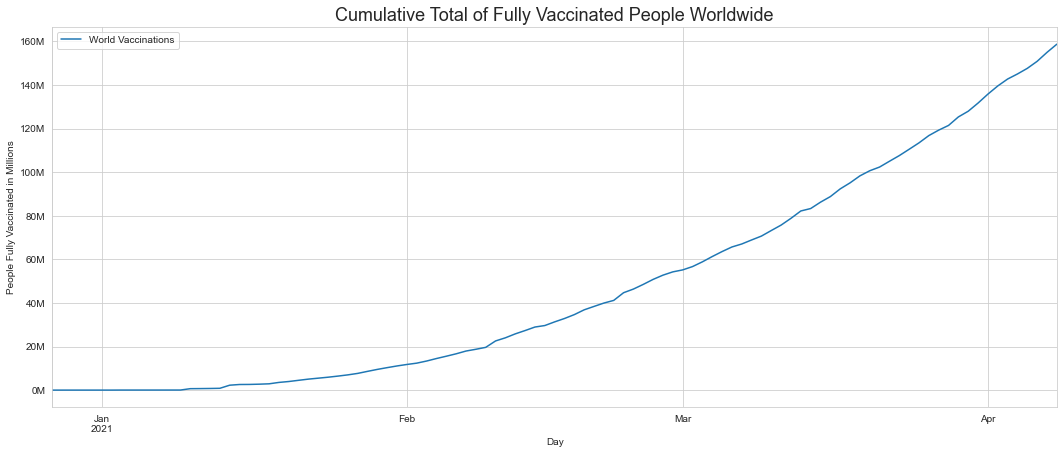

In [6]:
# Change format of y labels to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

# plot World vaccinations
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
world_df.plot(figsize= (18, 7), ax= ax)
plt.legend(['World Vaccinations'], fancybox= True)
plt.title('Cumulative Total of Fully Vaccinated People Worldwide', fontsize= 18)
plt.ylabel('People Fully Vaccinated in Millions')
plt.show()

Our data has an upward trend and will most likely have an exponential trend as more vaccines are approved for use, especially vaccines that only require one dose instead of two.

In [7]:
fig = px.line(world_df, x= world_df.index, y= 'people_fully_vaccinated')
fig.show()

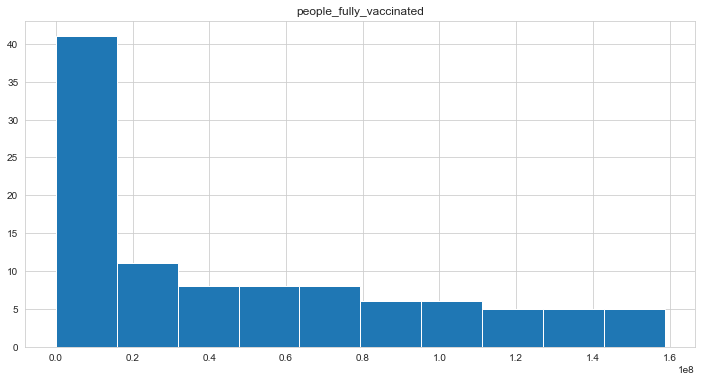

In [8]:
world_df.hist(figsize= (12,6))
plt.show()

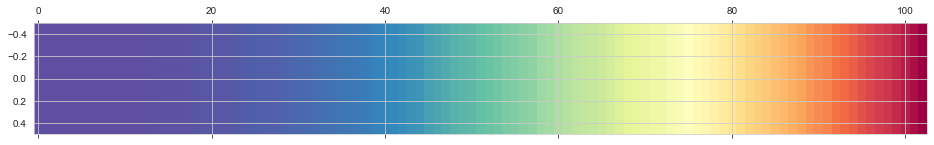

In [9]:
world_matrix = world_df.T
plt.matshow(world_matrix, interpolation= None, aspect= 'auto', cmap = plt.cm.Spectral_r);

As we would expect, the colors progress overtime and do seem to be increase as time progresses.

## Remove Trends

In [10]:
# Create function to calculate Dickey Fuller test and plot rolling statistics
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

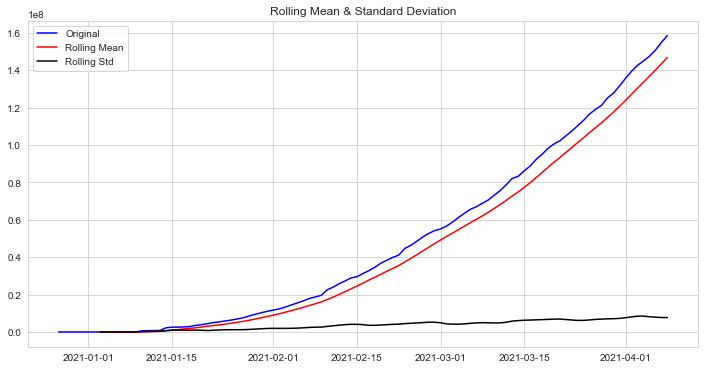

Results of Dickey-Fuller Test: 

Test Statistic                  0.613792
p-value                         0.987951
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [11]:
stationarity_check(world_df)

The p-value is almost 1 which means this is very much not a stationary time series.

Now we are certain there is a trend, it is time to remove it.

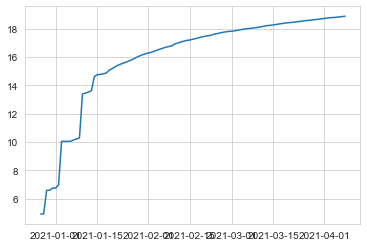

In [12]:
# Log transform data and see if that removed trend?
ts_log = np.log(world_df)
plt.plot(ts_log)

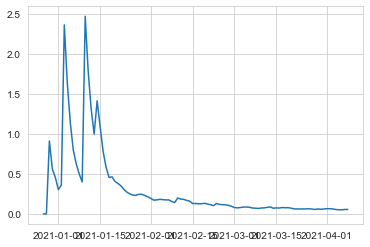

In [13]:
# Subtract the exponential weighted rolling mean with a halflife of 2
exponential_roll_mean = ts_log.ewm(halflife= 2).mean()
minus_exp_roll_mean = ts_log - exponential_roll_mean

plt.plot(minus_exp_roll_mean)

In [14]:
# Finally, use differencing to remove enough trend to get a low p-value
differencing = minus_exp_roll_mean.diff(periods= 4)
differencing.dropna(inplace= True)

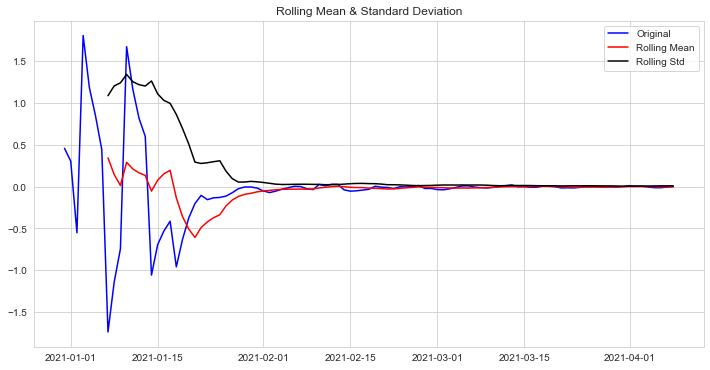

Results of Dickey-Fuller Test: 

Test Statistic                 -4.758205
p-value                         0.000065
#Lags Used                     11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [15]:
# visualize data after differencing and check p-value with Dickey Fuller test
stationarity_check(differencing)

**P-Value = 0.023**  -- This is a low enough p-value to consider any trends erased and we can now use this data to model and predict.

Now let's try decomposition and see if performs better than differencing.

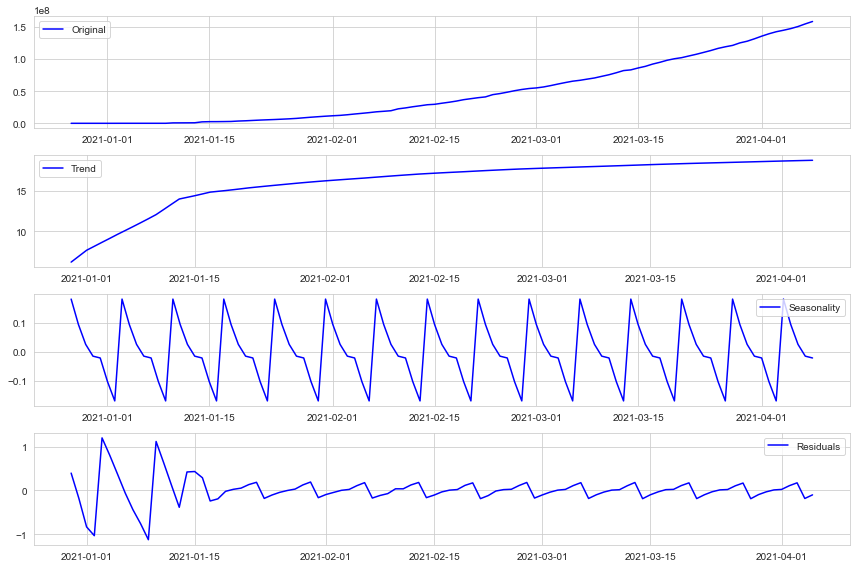

In [16]:
# calculate decomposition and separate the components
decomposition = seasonal_decompose(np.log(world_df), model= 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(world_df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

Text(0.5, 1.0, 'Decomposed World Vaccination Data')

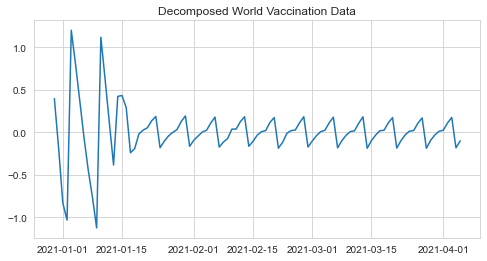

In [17]:
# use only the residuals to build decomposed data
ts_log_decompose = residual
ts_log_decompose.dropna(inplace= True)

plt.figure(figsize= (8, 4))
plt.plot(ts_log_decompose)
plt.title('Decomposed World Vaccination Data')

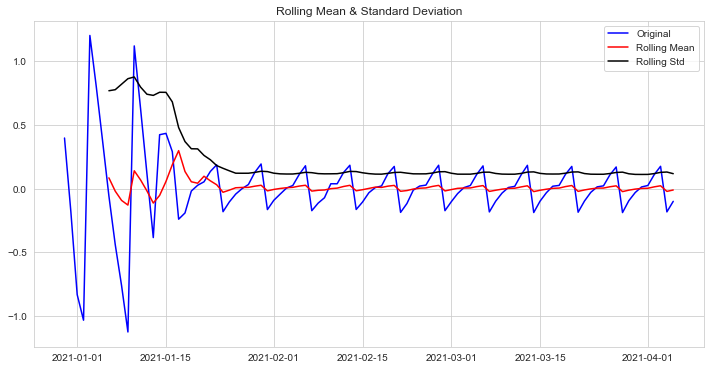

Results of Dickey-Fuller Test: 

Test Statistic                -6.255269e+00
p-value                        4.354437e-08
#Lags Used                     7.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (1%)           -3.506057e+00
Critical Value (5%)           -2.894607e+00
Critical Value (10%)          -2.584410e+00
dtype: float64


In [18]:
stationarity_check(ts_log_decompose)

This shows a **p-value of 0.00000** - can't get it any lower than that!

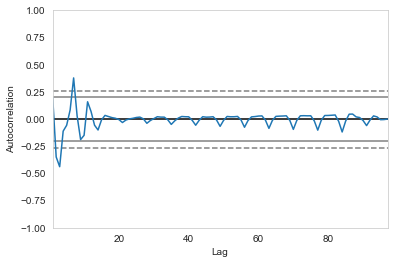

In [19]:
# use pandas autocorrelation plot to view all lags
autocorrelation_plot(ts_log_decompose)
plt.show()

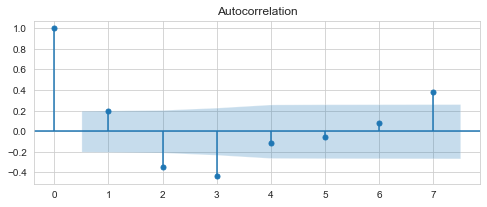

In [20]:
# plot ACF 
fig, ax = plt.subplots(figsize= (8, 3))
plot_acf(ts_log_decompose, ax= ax, lags= 7);

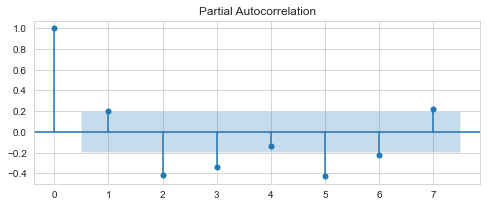

In [21]:
#plot PACF
fig, ax = plt.subplots(figsize= (8, 3))
plot_pacf(ts_log_decompose, ax= ax, lags= 7);

## Calculations of World Population

In [22]:
# calculate number of people that need to be vaccinated worldwide 
# to reach herd immunity

world_pop = 7874965825
print('World Population in 2021: {:,.0f}'.format(world_pop))

#26% of population under 16 yrs old
pop_percent_under_16 = .26
w_pop_over16 = world_pop * (1 - pop_percent_under_16)
print('Population over 16 years old: {:,.0f}'.format(w_pop_over16))

herd_immunity = .7
pop_need_fully_vax = w_pop_over16 * herd_immunity
print('Herd Immunity : {}%'.format(herd_immunity *100))
print('Population that needs to be vaccinated for herd immunity: {:,.0f}'\
      .format(pop_need_fully_vax) )

World Population in 2021: 7,874,965,825
Population over 16 years old: 5,827,474,710
Herd Immunity : 70.0%
Population that needs to be vaccinated for herd immunity: 4,079,232,297


We will try to build a model that can predict when almost 4.1 billion people will be vaccinated

In [23]:
# create DataFrame to keep results from models
cols = ['model', 'RMSE', 'MAPE', '70p_herd_imm']
results_df = pd.DataFrame(columns= cols)

## Time Series Modeling

### Model using PMD ARIMA

In [24]:
# check Augmented Dickey Fuller test
adf_test = ADFTest(alpha= 0.05)
adf_test.should_diff(world_df)

(0.99, True)

In [25]:
# a train/test split
train, test = train_test_split(world_df, test_size= 0.1)

In [26]:
train.shape

(92, 1)

In [27]:
test.shape

(11, 1)

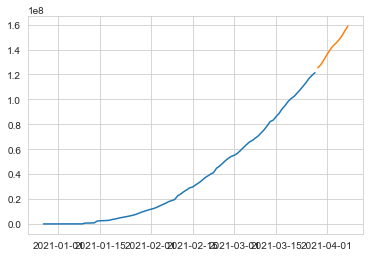

In [28]:
# plot train and test
plt.plot(train)
plt.plot(test)
plt.show()

In [29]:
# instantiate and fit model using pmdarima library
pmd_model = pm.auto_arima(train, stepwise= True, m= 7)
pmd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 7)   Log Likelihood               -1305.252
Date:                             Wed, 14 Apr 2021   AIC                           2622.504
Time:                                     13:23:16   BIC                           2637.503
Sample:                                          0   HQIC                          2628.553
                                              - 92                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6271      0.743     -0.844      0.399      -2.084       0.829
ma.L1         -0.3310      0.817     -0.405      0.685      -1.933       1.271
ma.L2         -0.4076      0.692     -0.589      0.556      -1.763       0.948
ar.S.L7        0.8742      0.265      3.300      0.001       0.355       1.393
ma.S.L7       -0.6003      0.384     -1.563      0.118      -1.353       0.152
sigma2      2.887e+11   1.41e-11   2.04e+22      0.000    2.89e+11    2.89e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               103.09
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.88   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.6e+37. Standard errors may be unstable.
"""

In [30]:
# calculate RMSE
preds, conf_int = pmd_model.predict(n_periods=test.shape[0], return_conf_int=True)
pmd_rmse = mean_squared_error(test, preds, squared= False)
print('PMD RMSE: {:,.2f}'.format(pmd_rmse))

PMD RMSE: 3,462,363.42


In [31]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
pmd_mape = round(np.mean(np.abs((test.values - preds)/test.values))* 100, 3)  
print('PMD MAPE: {}'.format(pmd_mape))

PMD MAPE: 8.149


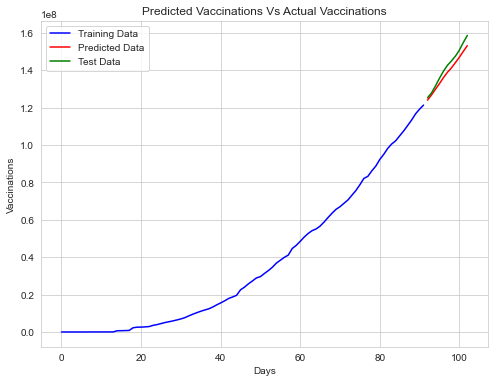

In [32]:
# plot test and predicted data
x = np.arange(world_df.shape[0])
n = train.shape[0]

plt.figure(figsize= (8, 6))
plt.plot(x[:n], train, c='blue', label= 'Training Data')
plt.plot(x[n:], preds, c='red', label= 'Predicted Data')
plt.plot(x[n:], test, c= 'green', label= 'Test Data')
plt.title('Predicted Vaccinations Vs Actual Vaccinations')
plt.xlabel('Days')
plt.ylabel('Vaccinations')
plt.legend()
plt.show()

In [33]:
# predict next 21 days
next_n = pmd_model.predict(n_periods= 21)
# next_n

In [34]:
# Use bokeh to plot predictions
import bokeh.io

bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter

Loading BokehJS ...

In [35]:
# function to plot data
def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth_idx = np.arange(truth.shape[0])
    truths = truth.loc[:, 'people_fully_vaccinated']
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth_idx, truths.values, legend_label='Observed', 
           line_width= 3, line_color = '#0099ff')
    p.line(forecasts.index, forecasts.values, legend_label='Forecasted', 
           line_width= 3, line_color= '#ff9933')
    
    p.yaxis[0].formatter = NumeralTickFormatter(format= '0.0a')
    p.legend.location = 'bottom_right'
    
    return p

In [36]:
# show plot
show(plot_arima(world_df, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

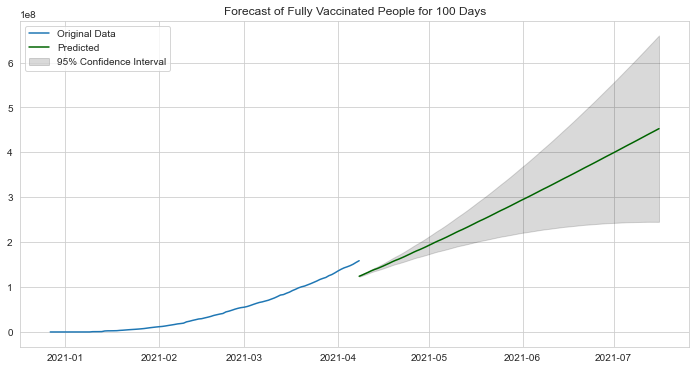

In [37]:
# plot using matplotlib and showing confidence interval
n_periods = 100
fitted, confint = pmd_model.predict(n_periods= n_periods, return_conf_int= True)
index_of_fc = pd.date_range(world_df.index[-1], periods= n_periods, freq= 'd')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#plot figure
plt.figure(figsize= (12, 6))
plt.plot(world_df, label= 'Original Data')
plt.plot(fitted_series, color= 'darkgreen', label= 'Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color= 'k', 
                 alpha= 0.15, label= '95% Confidence Interval')
plt.title('Forecast of Fully Vaccinated People for 100 Days')
plt.legend(loc= 'upper left')
plt.show()

In [38]:
# predict for 1475 days into the future
next_n = pmd_model.predict(n_periods= 1475)

# plot
show(plot_arima(world_df, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

In [39]:
# calculate that into years
pmd_imm = (1475 + len(world_df)) / 365
print('# of years until reaching herd immunity:', round(pmd_imm, 1))

# of years until reaching herd immunity: 4.3


In [40]:
pmd_imm = datetime.date(2025, 8, 1)

In [41]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['PMD ARIMA', pmd_rmse, pmd_mape, pmd_imm]

### Model using statsmodels ARIMA

In [42]:
# use ARIMA from statsmodels to predict future vaccinations
sm_model = ARIMA(train, order= (0, 2, 1))
fitted = sm_model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                   90
Model:                         ARIMA(0, 2, 1)   Log Likelihood               -1306.674
Method:                               css-mle   S.D. of innovations         476679.270
Date:                        Wed, 14 Apr 2021   AIC                           2619.348
Time:                                13:23:17   BIC                           2626.847
Sample:                            12-29-2020   HQIC                          2622.372
                                 - 03-28-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              3.52e+04   1902.309     18.504      0.000    3.15e+04    3.89e+04
ma.L1.D2.people_fully_vaccinated    -1.0000      0.032    -31.268      0.000      -1.063      -0.937
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
# get forecast, standard error and confidence interval
fc, se, conf = fitted.forecast(11, alpha= 0.05)

In [44]:
print(fitted.forecast())

(array([1.24374969e+08]), array([476679.27038101]), array([[1.23440695e+08, 1.25309243e+08]]))


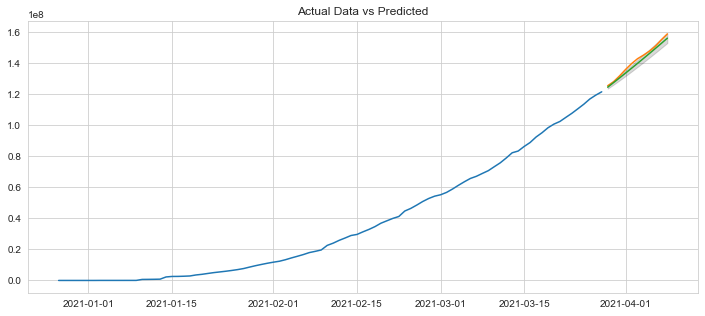

In [45]:
# create series to plot data
fc_series = pd.Series(fc, index= test.index)
lower_series = pd.Series(conf[:, 0], index= test.index)
upper_series = pd.Series(conf[:, 1], index= test.index)

# plot
plt.figure(figsize= (12, 5))
plt.plot(train, label= 'training')
plt.plot(test, label= 'test')
plt.plot(fc_series, label= 'forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color= 'k',  alpha= 0.15)
plt.title('Actual Data vs Predicted')
plt.show()

In [46]:
# calculate root mean squared error
sm_rmse = mean_squared_error(test.values, fc, squared= False)
print('RMSE: {:,.2f}'.format(sm_rmse))

RMSE: 2,084,257.03


In [47]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
sm_mape = round(np.mean(np.abs((test.values - fc)/test.values))*100, 3)  
print('MAPE:', sm_mape)

MAPE: 8.381


This model is about 92% accurate in predicting the next 8 days and predictions are about 933,000 people off. Not too bad when we are looking at 100's of millions of people.

#### Build model with whole dataset

In [48]:
# build and fit ARIMA model with whole dataset
# use p, d, q from auto_arima
model = ARIMA(world_df, order= (0, 2, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                  101
Model:                         ARIMA(0, 2, 1)   Log Likelihood               -1471.003
Method:                               css-mle   S.D. of innovations         500092.735
Date:                        Wed, 14 Apr 2021   AIC                           2948.005
Time:                                13:23:17   BIC                           2955.851
Sample:                            12-29-2020   HQIC                          2951.181
                                 - 04-08-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.664e+04   1681.753     21.785      0.000    3.33e+04    3.99e+04
ma.L1.D2.people_fully_vaccinated    -1.0000      0.027    -36.676      0.000      -1.053      -0.947
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

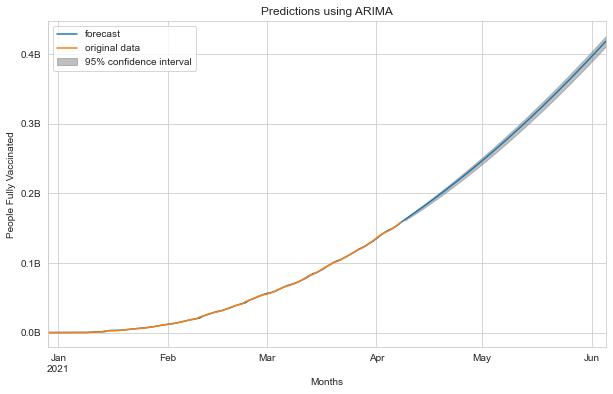

In [49]:
# Change format of y labels to billions
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(2, 160, ax= ax)

plt.title('Predictions using ARIMA')
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])
plt.show()

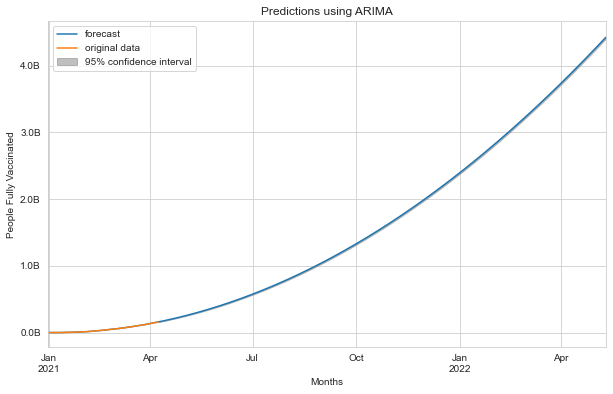

In [50]:
# Change format of y labels to billions
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(4, 500, ax= ax)

plt.title('Predictions using ARIMA')
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])
plt.show()

In [51]:
# calculate estimated immunity
sm_imm = (485 - len(world_df)) 
sm_imm = datetime.date(2022, 5, 1)

In [52]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['SM ARIMA', sm_rmse, sm_mape, sm_imm]

#### ARIMA Grid Search and SARIMAX

In [53]:
def arima_grid_search():
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 4)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(world_df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df['aic'].idxmin()]

In [54]:
# takes approx 40 minutes to run
# arima_grid_search()

Uncomment the cell above to run or save time and view the results from this image.

![arima_grid_search](images/ARIMA_grid_search.png)

In [55]:
mod_train = sm.tsa.statespace.SARIMAX(train, order=(0,2,1), 
                                seasonal_order=(0,2,2,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax_results = mod_train.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                people_fully_vaccinated   No. Observations:                   92
Model:             SARIMAX(0, 2, 1)x(0, 2, [1, 2], 7)   Log Likelihood                -895.082
Date:                                Wed, 14 Apr 2021   AIC                           1798.164
Time:                                        13:23:18   BIC                           1806.542
Sample:                                    12-27-2020   HQIC                          1801.441
                                         - 03-28-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8724      0.332     -2.625      0.009      -1.524      -0.221
ma.S.L7       -1.6942      0.397     -4.271      0.000      -2.472      -0.917
ma.S.L14       0.6835      0.500      1.366      0.172      -0.297       1.664
sigma2      1.115e+12   1.78e-13   6.28e+24      0.000    1.11e+12    1.11e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):                33.94
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.11
Prob(H) (two-sided):                  0.73   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+40. Standard errors may be unstable.
"""

In [56]:
# get forecast, standard error and confidence interval
frcst= sarimax_results.forecast(11)

In [57]:
frcst.values

array([1.24114217e+08, 1.26940856e+08, 1.30157495e+08, 1.33255779e+08,
       1.36659678e+08, 1.39603426e+08, 1.41930853e+08, 1.44822118e+08,
       1.47830377e+08, 1.51212971e+08, 1.54479955e+08])

In [58]:
# calculate root mean squared error
smx_rmse = mean_squared_error(test.values, frcst, squared= False)
print('RMSE: {:,.2f}'.format(smx_rmse))

RMSE: 2,806,526.94


In [59]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
smx_mape = round(np.mean(np.abs((test.values - frcst.values)/test.values))*100, 3)  
print('MAPE:', smx_mape)

MAPE: 8.225


Now, we'll run the model on whole dataset and get the herd immunity estimate.

In [60]:
mod = sm.tsa.statespace.SARIMAX(world_df, order=(0,2,1), 
                                seasonal_order=(0,2,2,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax_results = mod.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                people_fully_vaccinated   No. Observations:                  103
Model:             SARIMAX(0, 2, 1)x(0, 2, [1, 2], 7)   Log Likelihood               -1059.971
Date:                                Wed, 14 Apr 2021   AIC                           2127.943
Time:                                        13:23:18   BIC                           2136.994
Sample:                                    12-27-2020   HQIC                          2131.542
                                         - 04-08-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8904      0.289     -3.077      0.002      -1.458      -0.323
ma.S.L7       -1.7122      0.319     -5.375      0.000      -2.337      -1.088
ma.S.L14       0.7200      0.362      1.988      0.047       0.010       1.430
sigma2      1.144e+12   9.42e-14   1.21e+25      0.000    1.14e+12    1.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                31.54
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.04
Prob(H) (two-sided):                  0.81   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.45e+40. Standard errors may be unstable.
"""

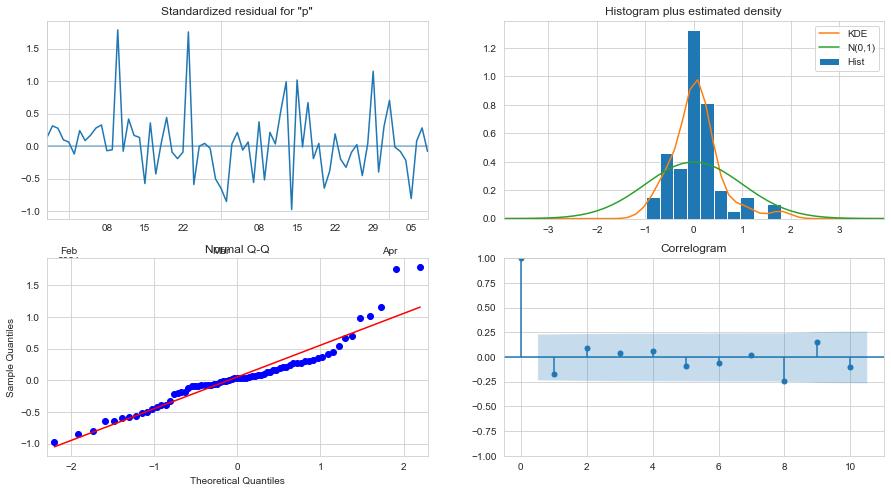

In [61]:
sarimax_results.plot_diagnostics(figsize= (15,8))
plt.show()

In [62]:
# function to get forecast and plot 
def get_forecast(steps):
    # Get forecast 500 steps ahead in future
    prediction = sarimax_results.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
#     Plot future predictions with confidence intervals
    formatter = FuncFormatter(billions)
    ax = world_df.plot(figsize= (15, 8))
    prediction.predicted_mean.plot(ax= ax)
    ax.yaxis.set_major_formatter(formatter)
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Month')
    ax.set_ylabel('People Fully Vaccinated')
    plt.title('SARIMAX Forecast', fontsize = 16)

    plt.legend(labels= ['forecast', 'original data', '95% confidence interval'], 
               loc= 'upper left')
    plt.show()

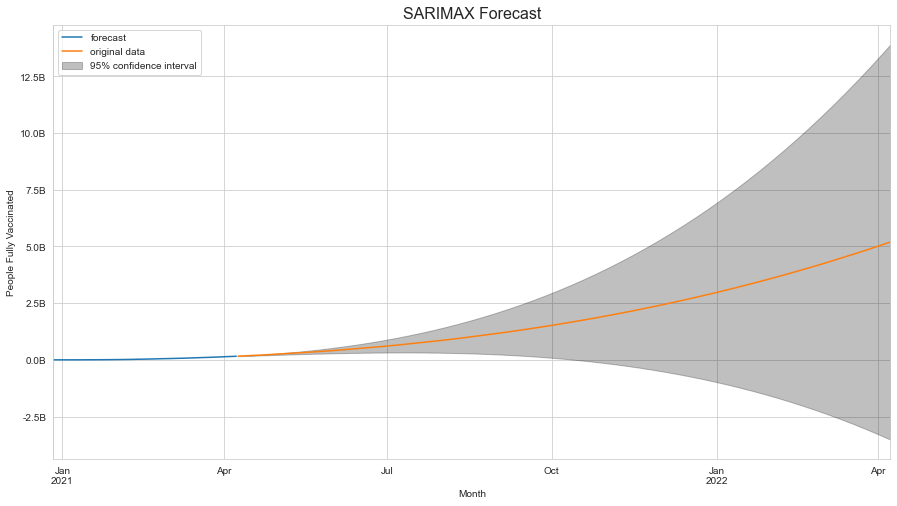

In [63]:
get_forecast(365)

In [64]:
smx_imm = datetime.date(2022, 3, 1)

In [65]:
# add results to DataFrame
results_df.loc[len(results_df.index)] = ['SM SARIMAX', smx_rmse, smx_mape, smx_imm]

SARIMAX predicts around March 2022

### Exponential Moving Average and Holt Exponential Smoothing

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly.

[image source here](https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572)

![ewm_holt_pyramid](images/Holt_ES2.png)

In [66]:
world = world_df.copy()

In [67]:
# get exponential weighted moving average using pandas
world['EWM'] = world['people_fully_vaccinated'].ewm(span= 3).mean()
world

people_fully_vaccinated           EWM
Day                                              
2020-12-27                    137.0  1.370000e+02
2020-12-28                    137.0  1.370000e+02
2020-12-29                    726.0  4.735714e+02
2020-12-30                    730.0  6.103333e+02
2020-12-31                    847.0  7.324839e+02
...                             ...           ...
2021-04-04              145021166.0  1.421344e+08
2021-04-05              147595945.0  1.448652e+08
2021-04-06              150826834.0  1.478460e+08
2021-04-07              154926238.0  1.513861e+08
2021-04-08              158688128.0  1.550371e+08

[103 rows x 2 columns]

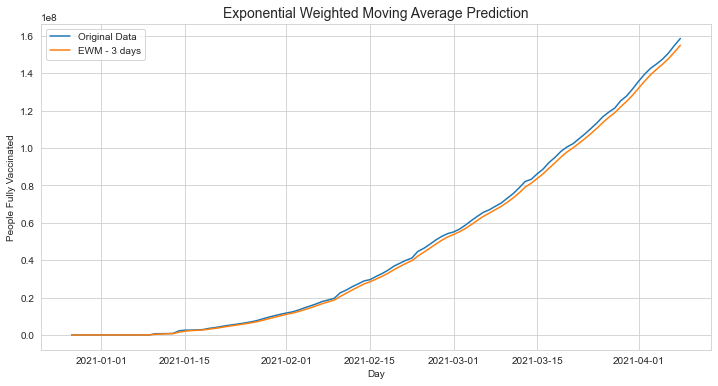

In [68]:
plt.figure(figsize= (12, 6))
plt.plot(world['people_fully_vaccinated'], label = 'Original Data')
plt.plot(world['EWM'], label= 'EWM - 3 days')
plt.title('Exponential Weighted Moving Average Prediction', fontsize= 14)
plt.xlabel('Day')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()

In [69]:
ewm_rmse = mean_squared_error(world['people_fully_vaccinated'], world['EWM'], squared= False)
print('EWM RMSE: {:,.2f}'.format(ewm_rmse))

EWM RMSE: 1,869,461.05


#### Holt Exponential Smoothing

Because the model does not have any seasonality (there barely has even been one season within this data) but does have an upward trend, I will try using Holt exponential smoothing.

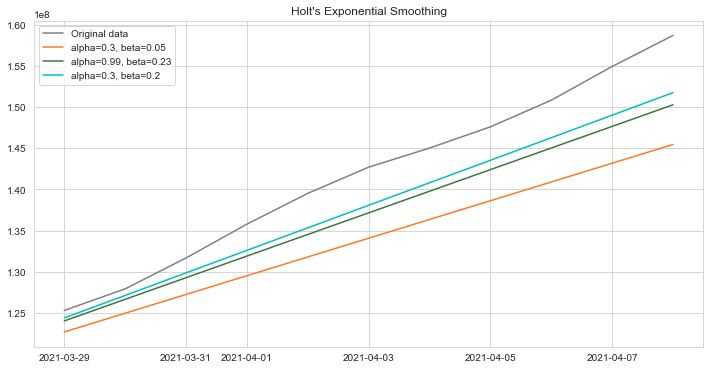

In [70]:
model = Holt(np.asarray(train['people_fully_vaccinated']))
model.index = train.index

n= len(test.values)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(n)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(n)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(n)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray", label= 'Original data')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color= 'r')
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [71]:
# set freq to days
world_df.index.freq = 'D'

In [72]:
# fit Holt model and get summary
holt_model = Holt(train, exponential= True)
fitted = holt_model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Holt Model Results                                
===================================================================================
Dep. Variable:     people_fully_vaccinated   No. Observations:                   92
Model:                                Holt   SSE                 44899174649038.102
Optimized:                            True   AIC                           2484.056
Trend:                      Multiplicative   BIC                           2494.143
Seasonal:                             None   AICC                          2485.044
Seasonal Periods:                     None   Date:                 Wed, 14 Apr 2021
Box-Cox:                             False   Time:                         13:23:20
Box-Cox Coeff.:                       None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5471429                alpha                 True
smoothing_trend            0.4588940                 beta                 True
initial_level              137.00000                  l.0                 True
initial_trend              1.0000000                  b.0                 True
------------------------------------------------------------------------------
"""

In [73]:
# n steps = length of test group
vax_forecast = fitted.forecast(steps= n)

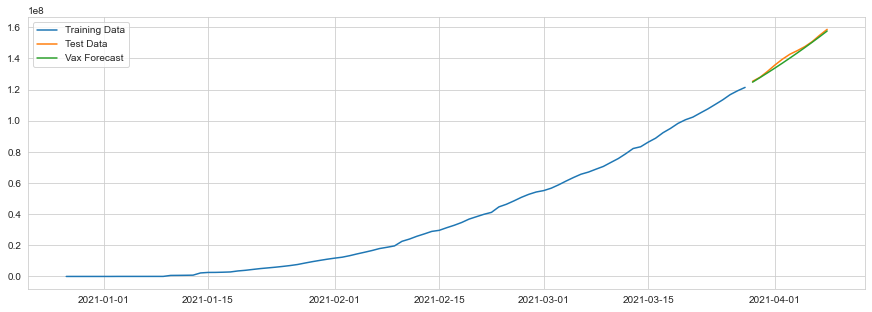

In [74]:
# plot
fig, ax = plt.subplots(figsize= (15,5))
plt.plot(train.index, train, label= 'Training Data')
plt.plot(test.index, test, label= 'Test Data')
plt.plot(test.index, vax_forecast, label= 'Vax Forecast')
plt.legend()
plt.show()

In [75]:
# get RMSE for Holt model
holt_rmse = mean_squared_error(test, vax_forecast, squared= False)
print('Holt RMSE: {:,.2f}'.format(holt_rmse))

Holt RMSE: 1,418,561.31


In [76]:
# forecast out n days
vax_far_forecast = fitted.forecast(steps= 90)

In [77]:
#predict 90 days ahead
n_input= len(train.values)

add_dates = [world_df.index[-1] + DateOffset(days= x) for x in range(0, 90)]
future_dates = pd.DataFrame(index= add_dates[1:], columns= world_df.columns)

df_predict = pd.DataFrame(vax_far_forecast, index= future_dates[-n_input:].index, 
columns= ['Holt Prediction'])
df_proj = pd.concat([world_df, df_predict], axis= 1)

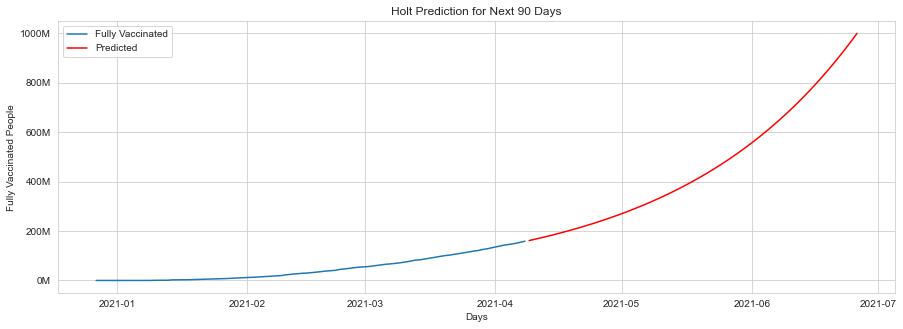

In [78]:
# Change format of y labels to billions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize= (15,5))
ax.yaxis.set_major_formatter(formatter)
plt.plot(df_proj.index, df_proj['people_fully_vaccinated'])
plt.plot(df_proj.index, df_proj['Holt Prediction'], color= 'r')
plt.title('Holt Prediction for Next 90 Days')
plt.xlabel('Days')
plt.ylabel('Fully Vaccinated People')
plt.legend(labels= ['Fully Vaccinated', 'Predicted'])
plt.show()

The Holt Model predicts the World will hit 1 billion fully vaccinated people before July 2021.

Unfortunately, the model was not able to predict more than 90 days ahead.

### LSTM

In [79]:
# set X values and reshape to use in LSTM
X = world_df.values
X = X.reshape((-1,1))

In [80]:
# split for train / test
split_percent = 0.9
split = int(split_percent * len(X))

X_train = X[:split]
X_test = X[split:]

date_train = world_df.index[:split]
date_test = world_df.index[split:]

print(len(X_train))
print(len(X_test))

92
11


In [81]:
# use Time series generator and set look back to 3 days
look_back = 3
train_gen = TimeseriesGenerator(X_train, X_train, length= look_back, batch_size= 1)
test_gen = TimeseriesGenerator(X_test, X_test, length= look_back, batch_size= 1)

In [82]:
# set layers for LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, activation= 'relu', input_shape= (look_back, 1), 
                    return_sequences= True))
lstm_model.add(LSTM(64, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
# lstm_model.add(LSTM(256, activation= 'relu', return_sequences= True))
# lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
# lstm_model.add(LSTM(128, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(64, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(32, activation= 'relu', return_sequences= True))
lstm_model.add(LSTM(1, activation= 'relu'))

lstm_model.compile(optimizer= 'Adam', loss= 'mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 32)             4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 64)             24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 64)             49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 32)             12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 136       
Total params: 189,960
Trainable params: 189,960
Non-trainable params: 0
__________________________________________________

In [83]:
lstm_model.fit(train_gen, epochs= 25)

Epoch 1/25
89/89 [==============================] - 1s 6ms/step - loss: 1770717976723456.0000
Epoch 2/25
89/89 [==============================] - 0s 5ms/step - loss: 11746022522880.0000
Epoch 3/25
89/89 [==============================] - 0s 5ms/step - loss: 26558804787200.0000
Epoch 4/25
89/89 [==============================] - 0s 5ms/step - loss: 172197452709888.0000
Epoch 5/25
89/89 [==============================] - 0s 5ms/step - loss: 15346051317760.0000
Epoch 6/25
89/89 [==============================] - 0s 5ms/step - loss: 39647375785984.0000
Epoch 7/25
89/89 [==============================] - 0s 5ms/step - loss: 16158404116480.0000
Epoch 8/25
89/89 [==============================] - 0s 5ms/step - loss: 6273116930048.0000
Epoch 9/25
89/89 [==============================] - 0s 5ms/step - loss: 7839275810816.0000
Epoch 10/25
89/89 [==============================] - 0s 5ms/step - loss: 7527546748928.0000
Epoch 11/25
89/89 [==============================] - 0s 5ms/step - loss: 565815

In [84]:
prediction = lstm_model.predict(test_gen)

In [85]:
# plot data
# reshape to plot
X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
prediction = prediction.reshape((-1))

# plot using plotly
trace1 = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = 'LSTM Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'People Fully Vaccinated'}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [86]:
# calculate RMSE
X_test = X_test[:8]
lstm_rmse = mean_squared_error(X_test, prediction, squared= False)
print('RMSE: {:,.2f}'.format(lstm_rmse))

RMSE: 17,776,410.11


In [87]:
# calculate MAPE (mean absolute percentage error)
# measure of prediction accuracy of a forecasting method in statistics
lstm_mape = round(np.mean(np.abs((X_test - prediction)/X_test))*100, 3)  
print('MAPE:', lstm_mape)

MAPE: 12.971


#### Forecasting with LSTM

In [88]:
# functions to forecast model
X = X.reshape((-1))

# predict future values (fully vaccinated people)
def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# create future dates for x-axis    
def predict_dates(num_prediction):
    last_date = world_df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

# num_prediction = number of days into future
num_prediction = 200
forecast = predict(num_prediction, lstm_model)
forecast_dates = predict_dates(num_prediction)

In [89]:
# plot data
trace1 = go.Scatter(
    x = world_df.index,
    y = X,
    mode = 'lines',
    name = 'Original Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecasted Data'
)
layout = go.Layout(
    title = 'LSTM Forecast',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'People Fully Vaccinated'}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [90]:
# herd immunity date
lstm_imm = datetime.date(2021, 9, 15)

In [91]:
# add to df
results_df.loc[len(results_df.index)] = ['LSTM', lstm_rmse, lstm_mape, lstm_imm]

### Results

In [92]:
results_df

model          RMSE    MAPE 70p_herd_imm
0   PMD ARIMA  3.462363e+06   8.149   2025-08-01
1    SM ARIMA  2.084257e+06   8.381   2022-05-01
2  SM SARIMAX  2.806527e+06   8.225   2022-03-01
3        LSTM  1.777641e+07  12.971   2021-09-15

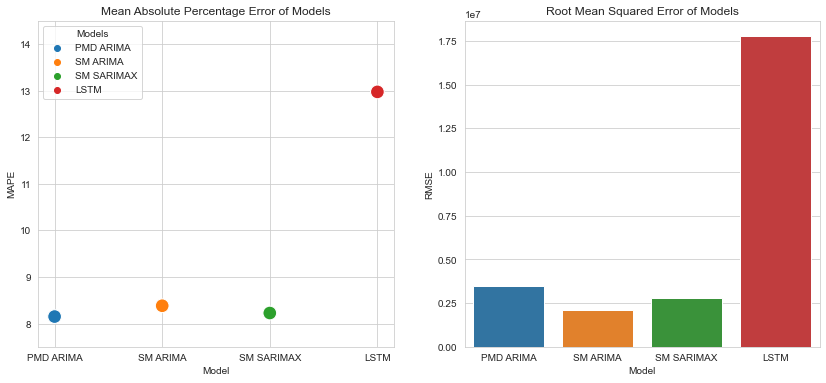

In [93]:
fig = plt.figure(figsize= (14, 6))
ax = fig.add_subplot(121)
sns.scatterplot('model', 'MAPE', data = results_df, ax= ax, hue= 'model', s= 190)
ax.set_title('Mean Absolute Percentage Error of Models')
ax.set_xlabel('Model')
ax.legend(title= 'Models')
ax.set_ylim(7.5, 14.5)


ax1 = fig.add_subplot(122)
sns.barplot('model', 'RMSE', data = results_df, ax= ax1)
ax1.set_title('Root Mean Squared Error of Models')
ax1.set_xlabel('Model');

In [94]:
# set date as index to plot
results_df.set_index('70p_herd_imm', inplace= True)

In [95]:
# plot predicted dates
fig = px.scatter(results_df, 
                 x= results_df.index, 
                 y= 'model', 
                 color= 'model')

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title= 'Predicted 70% Herd Immunity Dates', 
    xaxis_title= '70% Herd Immunity Prediction Date', 
    yaxis_title = 'Model')

fig.show()

### Conclusion

All three of the ARIMA models were similar when looking at mean absolute percentage error, with the statsmodels model slightly higher. However, when looking at how far off those points were, the two statsmodels models were able to get closer to the actual data (lower RMSE).

When looking at the RMSE and MAPE, either of the ARIMA models would be a reasonable choice. However, when you look at the forecasted herd immunity, it appears that the **statsmodels models** might potentially be more accurate. It seems more likely that it would take approximately a year, rather than a few months or 4 years. 

In the end, time will tell which one of these models is accurate.

### Disclaimer
- removing people under 16 from population, but different regions will have different ratio of minors and adults [see here](https://www.statista.com/statistics/265759/world-population-by-age-and-region/)
- fully vaccinated means person has received 2 shots. New vaccines are emerging that only require one shot and will throw off the prediction
- different parts of the world are vaccinating at different rates. There will be some countries that will reach 70% vaccinated before others
- approval of new vaccinations is not accounted for, nor is the removal of previously approved vaccinations
- herd immunity assumes the vaccinations will continue to be effective, which may or may not be the case

## Updated Data

When I started this project at the end of March, there was not a whole lot of data available. Some countries had not yet begun vaccinations (and still as of June 1st, there are some countries that have yet to receive any vaccinations). With an extra two months worth of data, I hope the models I built previously are better adept at making predictions.

In [2]:
# load new data
df_new = pd.read_csv('../data/6-1-people-fully-vaccinated-covid.csv')

In [3]:
df_new.head()

Entity Code         Day  people_fully_vaccinated
0  Afghanistan  AFG  2021-05-11                    55624
1  Afghanistan  AFG  2021-05-20                    77560
2  Afghanistan  AFG  2021-05-24                    96910
3  Afghanistan  AFG  2021-05-26                   111082
4  Afghanistan  AFG  2021-05-27                   113739

In [4]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10553 entries, 0 to 10552
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Entity                   10553 non-null  object
 1   Code                     8521 non-null   object
 2   Day                      10553 non-null  object
 3   people_fully_vaccinated  10553 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 329.9+ KB


In [5]:
df_new['Day'] = pd.to_datetime(df_new['Day'])

In [6]:
new_ts = df_new.copy()

In [7]:
new_ts.set_index('Day', inplace= True)

In [8]:
new_ts.Entity.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Brazil', 'British Virgin Islands',
       'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic',
       'Chile', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia',
       'Curacao', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England',
       'Equatorial Guinea', 'Estonia', 'Europe', 'European Union',
       'Faeroe Islands', 'Falkland Islands', 'Finland', 'France',
       'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Gibraltar', 'Greece'

In [9]:
ts_world = new_ts.where(new_ts['Entity'] == 'World')
ts_world.dropna(inplace= True)
ts_world.drop(['Code', 'Entity'], axis= 1, inplace= True)

In [10]:
ts_world

people_fully_vaccinated
Day                                
2020-12-27                     14.0
2020-12-28                     52.0
2020-12-29                    783.0
2020-12-30                    912.0
2020-12-31                   1061.0
...                             ...
2021-05-27              414771680.0
2021-05-28              419760225.0
2021-05-29              423563234.0
2021-05-30              427421843.0
2021-05-31              430361678.0

[156 rows x 1 columns]

In [11]:
fig = px.line(ts_world, x= ts_world.index, y= 'people_fully_vaccinated')
fig.show()

In [14]:
# check Augmented Dickey Fuller test
adf_test = ADFTest(alpha= 0.05)
adf_test.should_diff(ts_world)

(0.8224670874732675, True)

In [15]:
trn, tst = train_test_split(ts_world, test_size= 0.2)

In [24]:
tst.count()

people_fully_vaccinated    32
dtype: int64

In [29]:
# instantiate and fit model using pmdarima library
pmd_model2 = pm.auto_arima(trn, stepwise= True, m= 1)
pmd_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1798.156
Date:                Wed, 02 Jun 2021   AIC                           3600.312
Time:                        16:16:37   BIC                           3605.920
Sample:                             0   HQIC                          3602.590
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6818      0.061    -11.229      0.000      -0.801      -0.563
sigma2      4.087e+11   5.64e-15   7.25e+25      0.000    4.09e+11    4.09e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.33
Prob(Q):                              0.82   Prob(JB):                         0.02
Heteroskedasticity (H):               7.87   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [32]:
# build and fit ARIMA model with whole dataset
# p, d, q from auto_arima gave p-value > 0.05 
# this p,d,q order gets lowest p-value for constant
model2 = ARIMA(ts_world, order= (1, 2, 1))
rslts = model2.fit()
rslts.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                  154
Model:                         ARIMA(1, 2, 1)   Log Likelihood               -2300.582
Method:                               css-mle   S.D. of innovations         741846.428
Date:                        Wed, 02 Jun 2021   AIC                           4609.164
Time:                                16:17:04   BIC                           4621.312
Sample:                            12-29-2020   HQIC                          4614.098
                                 - 05-31-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.251e+04   1.13e+04      2.877      0.004    1.04e+04    5.47e+04
ar.L1.D2.people_fully_vaccinated     0.3403      0.092      3.683      0.000       0.159       0.521
ma.L1.D2.people_fully_vaccinated    -0.8838      0.044    -20.143      0.000      -0.970      -0.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9385           +0.0000j            2.9385            0.0000
MA.1            1.1315           +0.0000j            1.1315            0.0000
-----------------------------------------------------------------------------
"""

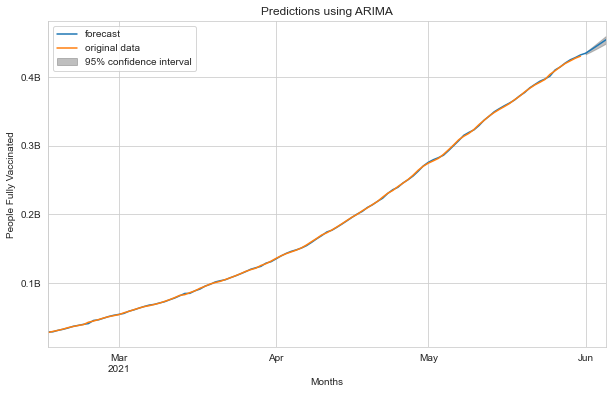

In [38]:
# Change format of y labels to billions
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
rslts.plot_predict(50, 160, ax= ax)

plt.title('Predictions using ARIMA')
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])
plt.show()